Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import display, Image
for n, i in enumerate(train_folders):
    sample = np.random.choice(os.listdir(i), 1)[0]
    random = os.path.join(i, sample)
    display(Image(filename=random))
#display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [5]:
#from IPython.display import Image
#def display_random_image ( folder, image ) :
#    Image(filename='test.png') 
# import os, random
# dir_name = "notMNIST_large"
# folder_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
# for folder in folder_names:
#    image_name = random.choice(os.listdir(dir_name + "/" + folder))
#    print ( folder, image_name )
#    im_file = dir_name + "/" + folder + "/" + im_name
#    print ( folder, im_file )
    
for n, i in enumerate(train_folders): # enumerate() returns the index and the item
        sample = np.random.choice(os.listdir(i), 1)[0] # this randomly selects a .png file in the given folder
        random = os.path.join(i, sample)
        print ( n, i, sample, random )

0 notMNIST_large/A VG9taXNtSVRDU3RkLm90Zg==.png notMNIST_large/A/VG9taXNtSVRDU3RkLm90Zg==.png
1 notMNIST_large/B QmxpdHprcmllZy50dGY=.png notMNIST_large/B/QmxpdHprcmllZy50dGY=.png
2 notMNIST_large/C U3RvbmVTYW5zU2VtaUJvbGQub3Rm.png notMNIST_large/C/U3RvbmVTYW5zU2VtaUJvbGQub3Rm.png
3 notMNIST_large/D S2VsdCBCb2xkLnR0Zg==.png notMNIST_large/D/S2VsdCBCb2xkLnR0Zg==.png
4 notMNIST_large/E Rml0dHN2YW1wLnR0Zg==.png notMNIST_large/E/Rml0dHN2YW1wLnR0Zg==.png
5 notMNIST_large/F TWVtbyBJdGFsaWMudHRm.png notMNIST_large/F/TWVtbyBJdGFsaWMudHRm.png
6 notMNIST_large/G S2hhbiBGaWxsLnR0Zg==.png notMNIST_large/G/S2hhbiBGaWxsLnR0Zg==.png
7 notMNIST_large/H QmFpbGV5IFNhbnMgSVRDIEJvbGQgSXRhbGljLnR0Zg==.png notMNIST_large/H/QmFpbGV5IFNhbnMgSVRDIEJvbGQgSXRhbGljLnR0Zg==.png
8 notMNIST_large/I QVRSb3Rpc1NlbWlTZXJpZi5vdGY=.png notMNIST_large/I/QVRSb3Rpc1NlbWlTZXJpZi5vdGY=.png
9 notMNIST_large/J R2lsdHVzVC1SZWd1bGFyLm90Zg==.png notMNIST_large/J/R2lsdHVzVC1SZWd1bGFyLm90Zg==.png


In [6]:
import os, random
dir_name = "notMNIST_large"
folder_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
for folder in folder_names:
    im_name = random.choice(os.listdir(dir_name + "/" + folder))
    im_file = dir_name + "/" + folder + "/" + im_name
    display(Image(filename=im_file))

In [7]:
import matplotlib.image as mpimg
def display_samples(folders, color = None):
    fig = plt.figure() # this creates a fig
    fig.set_figwidth(10); fig.set_figheight(4) # this changes the default figure size of Databricks
    for n, i in enumerate(folders): # enumerate() returns the index and the item
        sample = np.random.choice(os.listdir(i), 1)[0] # this randomly selects a .png file in the given folder
        random = os.path.join(i, sample) # this is the full path to the .png file
        img = mpimg.imread(random) # this produces a numpy array of the .png, a 28 by 28 numpy array of dtype float32
        ax = fig.add_subplot(2, 5, n + 1) # there are 10 subplots (A-J), a (rows) by b(columns) by c(figure number)
        ax = plt.imshow(img, cmap = color) # this produces <matplotlib.image.AxesImage> in black and white
    display(fig)

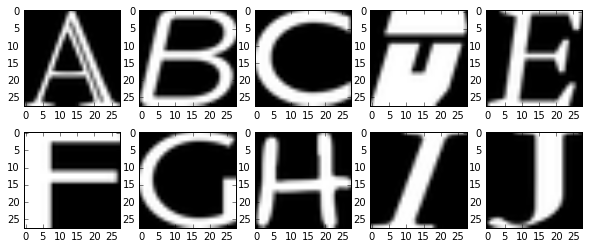

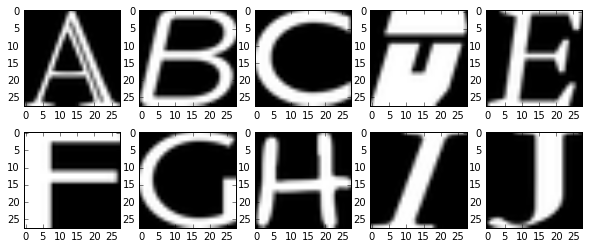

In [8]:
display_samples(train_folders, 'gray')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

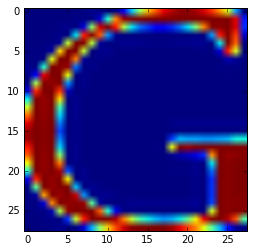

In [10]:
pickle_file = train_datasets[6]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)  # display it

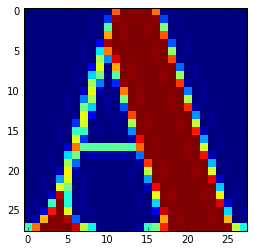

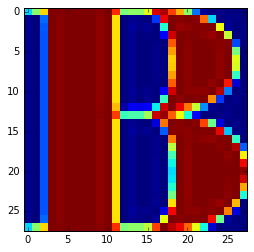

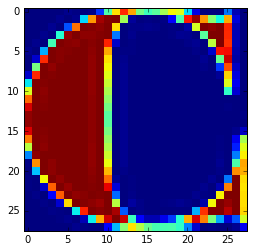

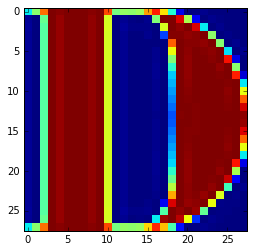

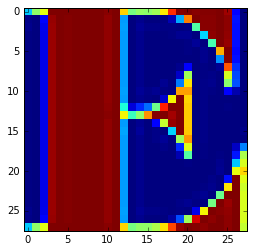

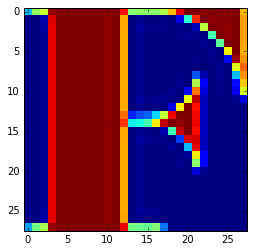

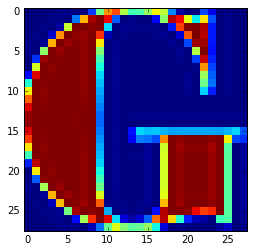

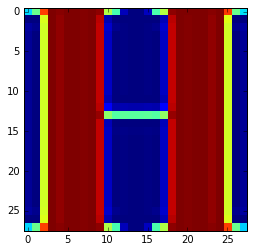

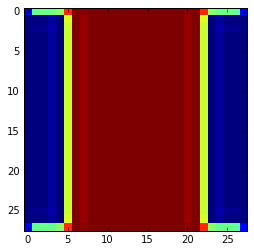

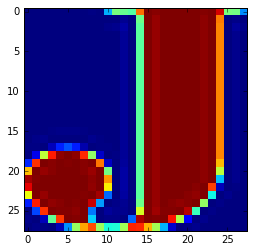

In [11]:
dir_name = "notMNIST_large"
folder_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
for folder in folder_names:
    im_file = dir_name + "/" + folder + ".pickle"
    image_sample = pickle.load ( open ( im_file, "r") )
    plt.imshow ( image_sample[5], interpolation='nearest' )
    plt.show ()

# first load the pickle file, loading one for illustration purpose
# t = pickle.load(open("notMNIST_large/C.pickle", "r"))
# plot one of image. the number 5 to be exactly
# plt.imshow(t[4], interpolation='nearest')
# show the image
# plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [12]:
len_dict = {}
for folder in folder_names:
    t = pickle.load(open(dir_name + "/" + folder + ".pickle", "r"))
    len_dict[folder] = len(t)
print(len_dict)
# calculate standard deviation here

{'A': 52909, 'C': 52912, 'B': 52911, 'E': 52912, 'D': 52911, 'G': 52912, 'F': 52912, 'I': 52912, 'H': 52912, 'J': 52911}


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [24]:
print(np.unique(train_labels))
print(np.unique(valid_labels))
print(np.unique(test_labels))
print(np.bincount(train_labels))
print(np.bincount(valid_labels))
print(np.bincount(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Finally, let's save the data for later reuse:

In [16]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [26]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
#print('Compressed pickle size:', statinfo)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [18]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))
def reshape(a):
    return a.reshape(a.shape[0],a.shape[1]*a.shape[2])
t = pickle.load(open("notMNIST.pickle", "r"))
unique_td = unique_rows(reshape(t['train_dataset']))
duplicate_rows = len(t['train_dataset']) - len(unique_td)
print(duplicate_rows)

12538


In [27]:
import hashlib
import time

def measure_overlap(a, b):
  '''a and b are ndarrays of shape (len, 28, 28)'''
  a.flags.writeable = False; b.flags.writeable = False
  
  start = time.clock()
  
  a_hashed = [hashlib.sha1(i).hexdigest() for i in a]
  b_hashed = [hashlib.sha1(i).hexdigest() for i in b]
  a_set = set(a_hashed)
  b_set = set(b_hashed)
  
  overlap = set.intersection(a_set, b_set)
  overlap_aInb = filter(lambda x: x in b_set, a_hashed)
  overlap_bIna = filter(lambda x: x in a_set, b_hashed)
  
  return overlap, overlap_aInb, overlap_bIna, time.clock() - start

tv_dups, tInv, vInt, tv_time = measure_overlap(train_dataset, valid_dataset)
tt_dups, trInte, teIntr, tt_time = measure_overlap(train_dataset, test_dataset)

print("Between Train and Validation: %d overlaps, %d Train in Validation, %d Validation in Train, %.2f sec"%(len(tv_dups), len(tInv), len(vInt), tv_time))
print("Between Train and Test: %d overlaps, %d Train in Test, %d Test in Train, %.2f sec"%(len(tt_dups), len(trInte), len(teIntr), tt_time))

Between Train and Validation: 914 overlaps, 3470 Train in Validation, 1042 Validation in Train, 1.11 sec
Between Train and Test: 1118 overlaps, 3488 Train in Test, 1274 Test in Train, 1.08 sec


In [28]:
def sanitize(a, a_labels, b):
  '''sanitize a based on b'''
  start = time.clock()
  
  a_hashed = [hashlib.sha1(i).hexdigest() for i in a]
  b_hashed = [hashlib.sha1(i).hexdigest() for i in b]
  aNotInb = ~ np.in1d(a_hashed, b_hashed)
  
#   b_set = set([hashlib.sha1(i).hexdigest() for i in b])
#   a_dict = dict(zip(a_hashed, a))
#   aNotInb = filter(lambda x: x not in b_set, a_hashed)
#   a_sanitized = { k: a_dict[k] for k in aNotInb }

  return a[aNotInb], a_labels[aNotInb], time.clock() - start

valid_snt, valid_labels_snt, vt = sanitize(valid_dataset, valid_labels, train_dataset)
test_snt, test_labels_snt, tt = sanitize(test_dataset, test_labels, train_dataset)

print("Sanitized Validation dataset contains %d images, %.2f sec"%(len(valid_snt), vt))
print("Sanitized Test dataset contains %d images, %.2f sec"%(len(test_snt), tt))

Sanitized Validation dataset contains 8958 images, 1.16 sec
Sanitized Test dataset contains 8726 images, 1.13 sec


In [29]:
# compress images from 28 by 28 to 14 by 14
train_small = np.array([np.round(ndimage.zoom(i, .5), 1) for i in train_dataset])
valid_small = np.array([np.round(ndimage.zoom(i, .5), 1) for i in valid_dataset])
test_small = np.array([np.round(ndimage.zoom(i, .5), 1) for i in test_dataset])

In [30]:
tv_dups, tInv, vInt, tv_time = measure_overlap(train_small, valid_small)
tt_dups, trInte, teIntr, tt_time = measure_overlap(train_small, test_small)

print("Between reduced Train and Validation: %d overlaps, %d Train in Validation, %d Validation in Train, %.2f sec"%(len(tv_dups), len(tInv), len(vInt), tv_time))
print("Between reduced Train and Test: %d overlaps, %d Train in Test, %d Test in Train, %.2f sec"%(len(tt_dups), len(trInte), len(teIntr), tt_time))

valid_small_snt, valid_small_labels_snt, vt = sanitize(valid_small, valid_labels, train_small)
test_small_snt, test_small_labels_snt, tt = sanitize(test_small, test_labels, train_small)

print("Sanitized Validation dataset contains %d images, %.2f sec"%(len(valid_small_snt), vt))
print("Sanitized Test dataset contains %d images, %.2f sec"%(len(test_small_snt), tt))

Between reduced Train and Validation: 1002 overlaps, 4004 Train in Validation, 1144 Validation in Train, 0.57 sec
Between reduced Train and Test: 1184 overlaps, 3962 Train in Test, 1357 Test in Train, 0.49 sec
Sanitized Validation dataset contains 8856 images, 0.65 sec
Sanitized Test dataset contains 8643 images, 0.50 sec


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [19]:
def reshape(a):
    return a.reshape(a.shape[0],a.shape[1]*a.shape[2])
t = pickle.load(open("notMNIST.pickle", "r"))
y = t['train_labels']
X = reshape(t['train_dataset']) # reshape it to 2d array
del(t) # this should free up more memory spaces
# choose form 0:10000 because not enough memory for the docker
# probably a way to do batch learning with scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
C = 1.0
classifier = LogisticRegression(C=C, penalty='l1')
classifier.fit(X[0:10000], y[0:10000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_pred = classifier.predict(X)
classif_rate = np.mean(y_pred.ravel() == y.ravel()) * 100
print("classif_rate for %f " % (classif_rate))

classif_rate for 80.125000 


In [21]:
# we now see how it is predicted using sample 10001 to 20000, which is not used for training
# actually should calculate the accuracy in percentage.
print(y[10001:20000])
print(y_pred[10001:20000])

[1 5 1 ..., 2 4 7]
[8 5 1 ..., 2 0 7]


In [22]:
from sklearn import linear_model

clf_l = linear_model.LogisticRegression()
# we do not want to use the whole set, my old CPU would just melt
size = 20000 

# images are 28x28, we have to make a vector from them
tr = train_dataset[:size,:,:].reshape(size, 784)

# This is the most important line. I just feed the model 20k examples and it learns
clf_l.fit(tr, train_labels[:size])

# This is prediction on training set
prd_tr = clf_l.predict(tr)
print(float(sum(prd_tr == train_labels[:size]))/prd_tr.shape[0])
# prints 0.86 we are able to recognize 86% of the letters in the training set

# let's check if the model is not cheating, it has never seen
# the letters from the validation set before
prd_l = clf_l.predict(valid_dataset.reshape(valid_dataset.shape[0], 784))
float(sum(prd_l == valid_labels))/prd_l.shape[0]
# Cool 80% matches

0.87


0.7956

Model predicts: d
Should be: b


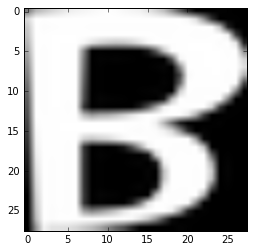

In [23]:
import numpy
import matplotlib.cm as cm

def num2char(num):
    return chr(num + ord('a'))

# indexes of letters that do not match 
# change the last number to get another letter
idx = numpy.where(prd_l != valid_labels)[0][20]
print("Model predicts: " + num2char(clf_l.predict(valid_dataset[idx].reshape(1, 784))))
print("Should be: " +num2char(valid_labels[idx]))
%matplotlib inline
plt.imshow(valid_dataset[idx,:,:] + 128,cmap = cm.Greys_r)

In [36]:
def simpleModel(data, labels, size):
  '''data is of shape (size, width, height)'''
  data = data.reshape(len(data), -1) # this reshapes the data into (size, width*height)
  r_list = np.random.choice(len(data), size, False)
  lr = LogisticRegression()
  lr.fit(data[r_list], labels[r_list])
  return lr, data[r_list], labels[r_list]

In [37]:
s0, s1, s2, s3, s4 = [], [], [], [], []
myrange = [50, 100, 500, 1000, 5000]
for size in myrange:
  myfit, train_x, label_x = simpleModel(train_dataset, train_labels, size)
  s0.append(myfit.score(train_x.reshape(len(train_x), -1), label_x))
  s1.append(myfit.score(valid_dataset.reshape(len(valid_dataset), -1), valid_labels))
  s2.append(myfit.score(test_dataset.reshape(len(test_dataset), -1), test_labels))
  s3.append(myfit.score(valid_snt.reshape(len(valid_snt), -1), valid_labels_snt))
  s4.append(myfit.score(test_snt.reshape(len(test_snt), -1), test_labels_snt))

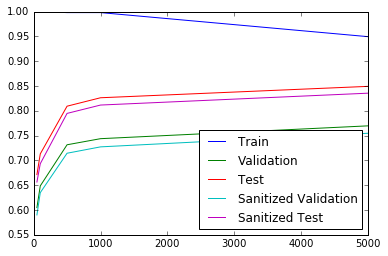

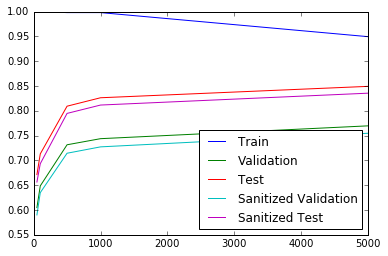

In [38]:
fig, ax = plt.subplots()
ax.plot(myrange, s0, myrange, s1, myrange, s2, myrange, s3, myrange, s4)
ax.legend(labels = ['Train', 'Validation', 'Test', 'Sanitized Validation', 'Sanitized Test'], loc = 4)
display(fig)

In [39]:
ss0, ss1, ss2, ss3, ss4 = [], [], [], [], []
for size in myrange:
  myfit, train_x, label_x = simpleModel(train_small, train_labels, size)
  ss0.append(myfit.score(train_x.reshape(len(train_x), -1), label_x))
  ss1.append(myfit.score(valid_small.reshape(len(valid_small), -1), valid_labels))
  ss2.append(myfit.score(test_small.reshape(len(test_small), -1), test_labels))
  ss3.append(myfit.score(valid_small_snt.reshape(len(valid_small_snt), -1), valid_small_labels_snt))
  ss4.append(myfit.score(test_small_snt.reshape(len(test_small_snt), -1), test_small_labels_snt))

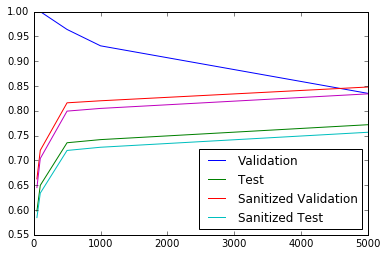

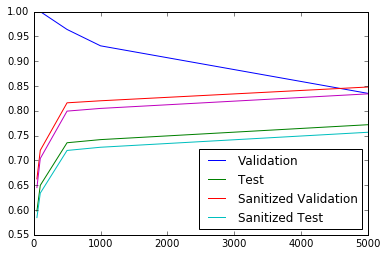

In [40]:
fig, ax = plt.subplots()
ax.plot(myrange, ss0, myrange, ss1, myrange, ss2, myrange, ss3, myrange, ss4)
ax.legend(labels = ['Validation', 'Test', 'Sanitized Validation', 'Sanitized Test'], loc = 4)
display(fig)

In [41]:
n_train = -1
X_train, y_train = train_dataset[:n_train].reshape(-1, train_dataset.shape[1]*train_dataset.shape[2]), train_labels[:n_train]
model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

Predictions
(10000, 784) (10000,)
Confusion matrix: 
Score:               precision    recall  f1-score   support

          A       0.81      0.84      0.83       961
          B       0.82      0.86      0.84       962
          C       0.86      0.85      0.86      1008
          D       0.87      0.86      0.86      1009
          E       0.77      0.83      0.80       930
          F       0.85      0.86      0.85       987
          G       0.83      0.81      0.82      1021
          H       0.83      0.80      0.81      1041
          I       0.79      0.74      0.76      1075
          J       0.82      0.82      0.82      1006

avg / total       0.83      0.83      0.82     10000



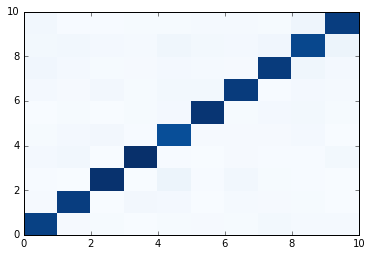

In [43]:
print("Predictions")
labels = [chr(k) for k in range(ord("A"), ord("J")+1)]
n_val = 10000
X_val, y_val = valid_dataset[:n_val].reshape(-1, valid_dataset.shape[1]*train_dataset.shape[2]), valid_labels[:n_val]
print(X_val.shape, y_val.shape)
y_pred = model.predict(X_val)
print("Confusion matrix: ")
plt.pcolor(confusion_matrix(y_pred, y_val), cmap="Blues")
print("Score: ", classification_report(y_pred, y_val, target_names=labels))

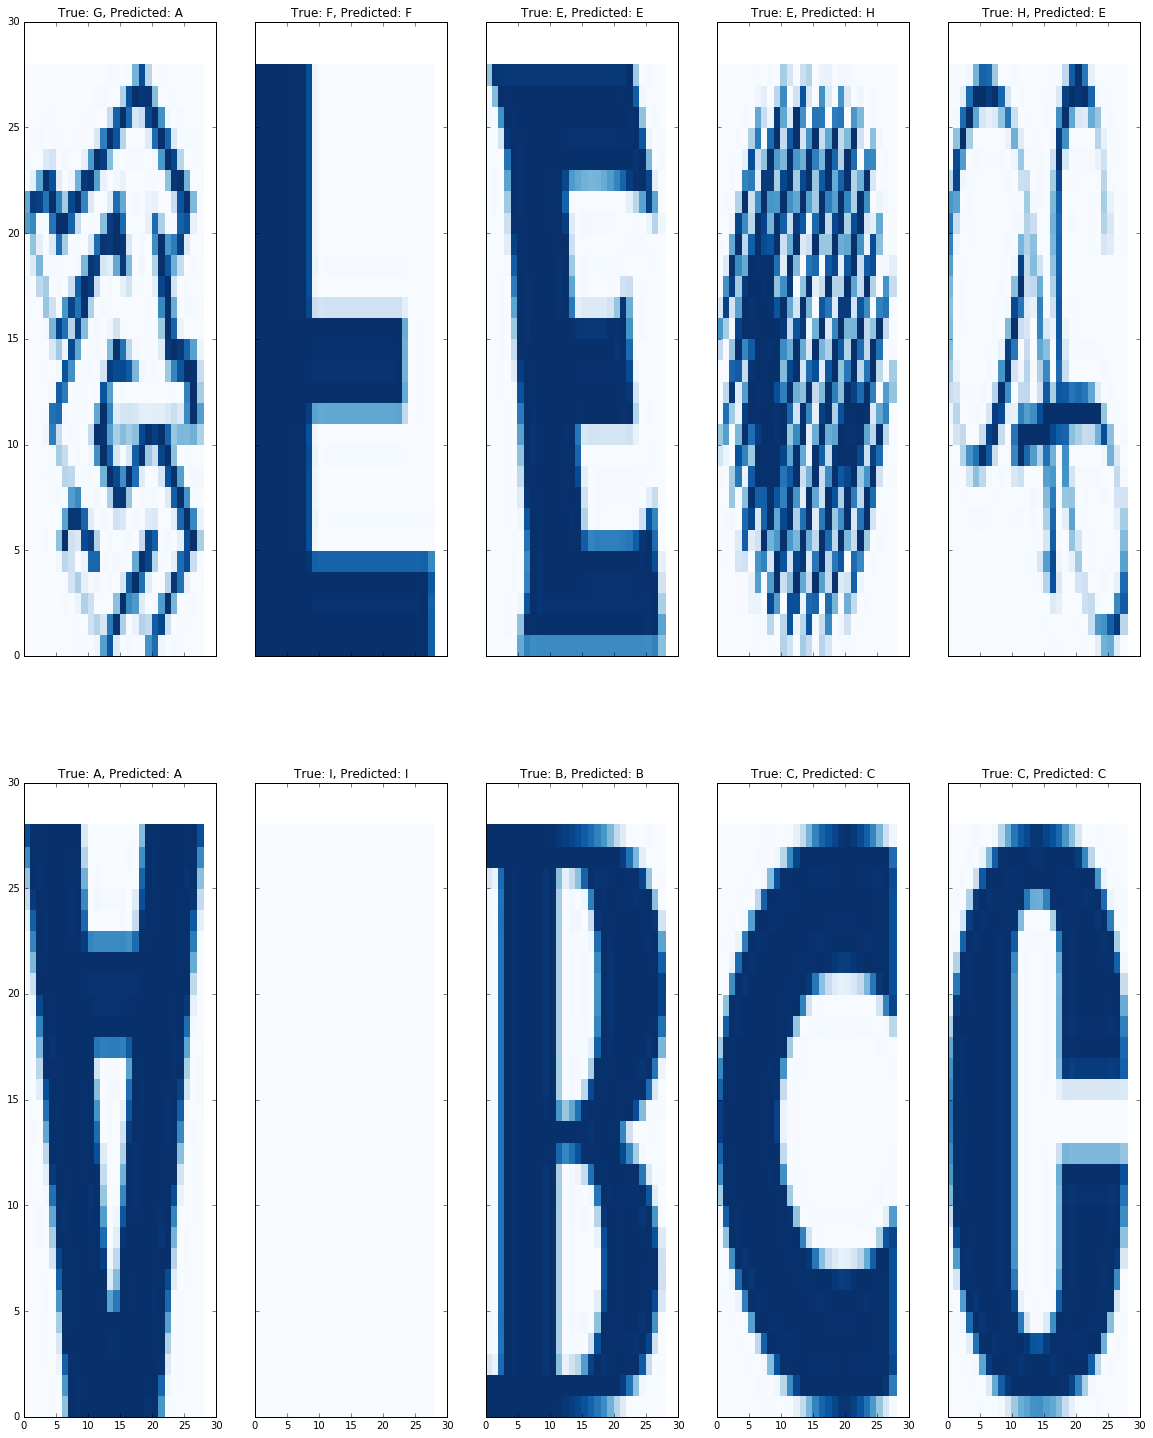

In [45]:
n_vis = 10
n_cols = 5
n_rows = int(n_vis/ n_cols)
idx = np.random.randint(valid_dataset.shape[0], size=n_vis)
X_vis, y_vis = valid_dataset[idx].reshape(-1, valid_dataset.shape[1]*valid_dataset.shape[2]), valid_labels[idx]
y_pred = model.predict(X_vis)
fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(n_rows, n_cols))
fig.set_size_inches(10*n_rows, 5*n_cols)
for i, axi in enumerate(ax.flatten()):
    axi.pcolor(X_vis[i].reshape(valid_dataset.shape[1], valid_dataset.shape[2]), cmap="Blues")
    axi.set_title("True: %s, Predicted: %s" % (labels[y_vis[i]], labels[y_pred[i]]))